# MELANOMA DETECTION ASSIGNMENT

## <font color="blue"> Introduction:

 Melanoma is a less common, but more serious cancer. Malignant melanoma can most successfully be cured when diagnosed at an early stage. Early detection of skin cancers like melanoma is crucial to ensure high chances of survival for patients. Clinical application of Deep Learning based decision support system for skin cancer screening has potential to improve the quality of patient care.



## <font color="blue"> Problem Statement:
Our aim is to build a CNN based model which can accurately predict the presence of melanoma and to provide a solution that can evaluate the images and alert dermatologist about the presence of melanoma which will reduce a lot of manual effort needed in diagnosis.

## <font color="blue"> Importing Important Libraries:

In [ ]:
# Importing the libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import PIL
import glob
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## <font color="blue"> Data Reading and Data Understanding:

In [ ]:
# Code for using dataset from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Importing the data using pathlib library
data_dir_train = pathlib.Path("/content/drive/MyDrive/Datasets/Skin cancer ISIC/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Datasets/Skin cancer ISIC/Test")
ISIC_folder_dir = pathlib.Path("/content/gdrive/MyDrive/Datasets/Skin cancer ISIC")

In [ ]:
# Checking the number of images in each category in test and train dataset
summary_df = pd.DataFrame(index=os.listdir(ISIC_folder_dir/"Train"), columns=["No_of_Train_Images", "No_of_Test_Images"])
for split in os.listdir(ISIC_folder_dir):
  for categories in os.listdir(ISIC_folder_dir/split):
    No_of_files = glob.glob(os.path.join(ISIC_folder_dir/split/categories, "*.jpg"))
    summary_df.loc[categories,"No_of_"+split+"_Images"] = int(len(No_of_files))
summary_df

,No_of_Train_Images,No_of_Test_Images
actinic keratosis,114,16
nevus,357,16
squamous cell carcinoma,181,16
vascular lesion,139,3
dermatofibroma,95,16
basal cell carcinoma,376,16
seborrheic keratosis,77,3
pigmented benign keratosis,462,16
melanoma,438,16


In [5]:
# Checking the total number of test and train images using glob library
image_count_train = len(list(data_dir_train.glob("*/*.jpg")))
print("Total number of training images are",image_count_train)
image_count_test = len(list(data_dir_test.glob("*/*.jpg")))
print("Total number of test images are",image_count_test)

Total number of training images are 2239
Total number of test images are 118


## <font color="blue"> Dataset Creation:

In [6]:
# Defining some parameters
batch_size = 32
img_height, img_width = 180, 180

In [7]:
# Creating train and validation dataset from the train directory using image_dataset_from_directory utility
# Using 80% of image for training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, seed=123, subset="training",
                                                               image_size=(img_height, img_width), validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Using 20% of image as validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, seed=123, subset="validation",
                                                             image_size=(img_height, img_width), validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing out the classes of skin cancer and storing it in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
# Ensuring the batch size and image size of train dataset
for image_batch, labels_batch in train_ds.take(1):
  print("The image batch is a tensor of shape",image_batch.shape)
  print("The label batch is a tensor of shape",labels_batch.shape)
  print("The shape of an image is",image_batch.numpy()[1].shape)

The image batch is a tensor of shape (32, 180, 180, 3)
The label batch is a tensor of shape (32,)
The shape of an image is (180, 180, 3)


## <font color="blue"> Data Visualization:

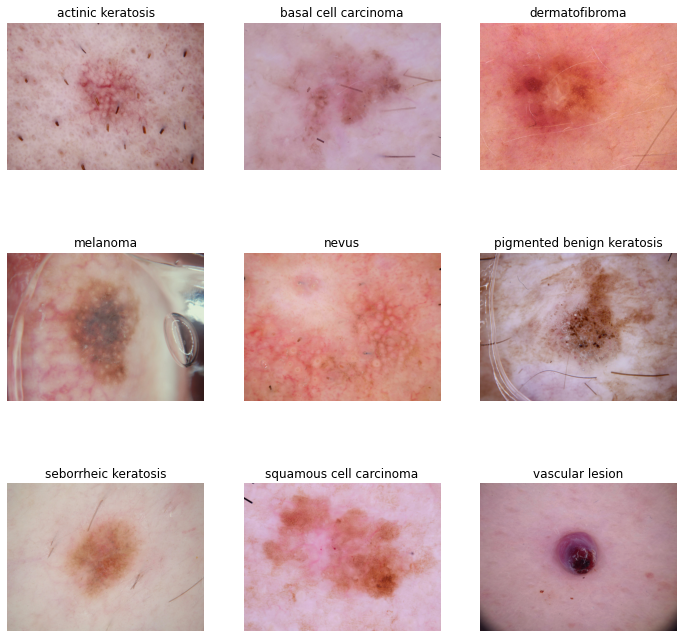

In [11]:
# Let's visualize a sample data from all the categories
plt.figure(figsize=[12,12])
for index,category in enumerate(class_names):
  plt.subplot(3,3,index+1)
  image = plt.imread(random.choice(list(data_dir_train.glob(category+"/*.jpg"))))
  plt.title(category)
  plt.imshow(image)
  plt.axis("off")

In [12]:
# Let's use autotune to determine the CPU budget to use for buffer_size while using prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Using prefetch to boost execution performance and caching for keeping the images in memory for the consecutive epochs
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## <font color="blue"> Base Model Building:

Building the model:

In [13]:
# Building a CNN network
num_classes = len(class_names)

# Adding layers to the network
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.25),

                    layers.Flatten(),
                    layers.Dense(64, activation="relu"),
                    layers.Dense(num_classes, activation="softmax")
])

Compiling the Model:

In [14]:
# Compiling the model
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [15]:
# Checking the summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 32)        9

Training the model:

In [16]:
# Training the model
epochs = 20 

# Fitting the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 18s 76ms/step - loss: 1.9123 - accuracy: 0.2952 - val_loss: 1.7368 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6343 - accuracy: 0.4224 - val_loss: 1.6072 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5549 - accuracy: 0.4509 - val_loss: 1.5308 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4622 - accuracy: 0.4754 - val_loss: 1.5022 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3541 - accuracy: 0.5156 - val_loss: 1.4103 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2786 - accuracy: 0.5463 - val_loss: 1.3678 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2246 - accuracy: 0.5709 - val_loss: 1.4084 - val_accuracy: 0.5414
Epoch 8/20
56/56 [=====

Visualizing the model performance:

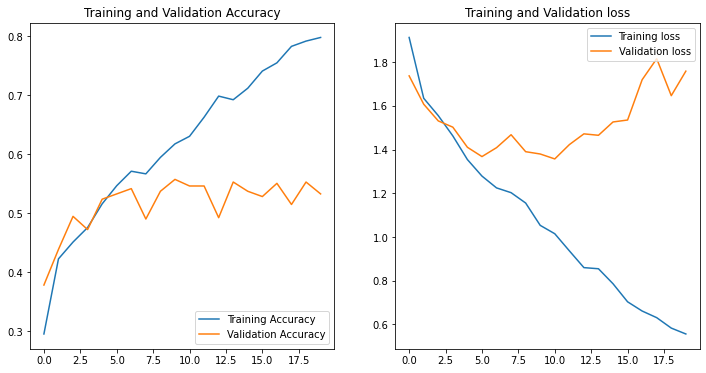

In [17]:
# Accuracy for train and validation dataset
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# Loss for train and validation dataset
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

# plotting the result
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend(loc="lower right")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend(loc="upper right")
plt.show()

Findings from the model:

- The above plots show that the training accuracy and validation accuracy are off by large margins. The training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. And the difference in accuracy between training and validation is noticeable, which is a sign of OVERFITTING.
- After around 60% of the training, the validation loss increases, and the training loss decreases linearly, which is the result of overfitting.


Suggestion:
- When there are small number of training examples, the model learn from the noises or unwanted details from the training dataset.
- So we can use data augmentation strategy to increase the number of training samples to avoid overfitting


## <font color="blue"> Data Augmentation

Choosing an appropriate data augmentation strategy:

In [18]:
# Creating augmentation strategy
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Visualizing some augmented examples:

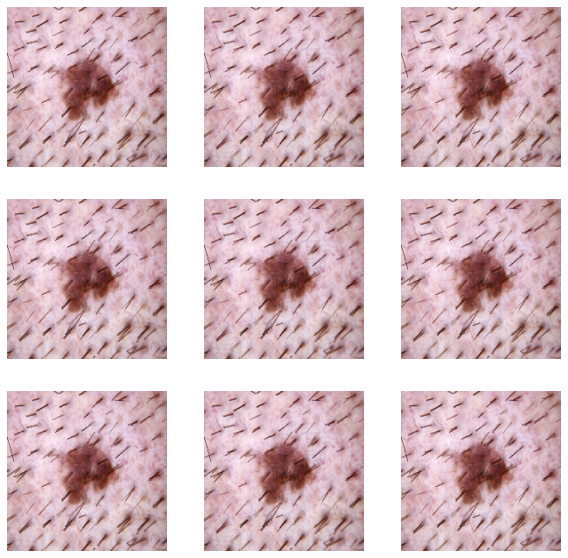

In [19]:
# Visualizing some augmented samples of same image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## <font color="blue"> Model Buiding using Augmented Data

Building the model using augmented data:

In [20]:
# Building a CNN network
num_classes = len(class_names)

# Adding layers to the network
model = Sequential([
                    data_augmentation,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.25),

                    layers.Flatten(),
                    layers.Dense(64, activation="relu"),
                    layers.Dense(num_classes, activation="softmax")])

Compiling the model:

In [21]:
# Compiling the model
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Training the model:

In [23]:
# Training the model
epochs = 20 

# Fitting the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 2s 27ms/step - loss: 2.0025 - accuracy: 0.2533 - val_loss: 1.7563 - val_accuracy: 0.3803
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6499 - accuracy: 0.4057 - val_loss: 1.7641 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6396 - accuracy: 0.4174 - val_loss: 1.5154 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5053 - accuracy: 0.4727 - val_loss: 1.4509 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4086 - accuracy: 0.5140 - val_loss: 1.4120 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3495 - accuracy: 0.5318 - val_loss: 1.4472 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3636 - accuracy: 0.5190 - val_loss: 1.3554 - val_accuracy: 0.5347
Epoch 8/20
56/56 [======

Visualizing the model performance:

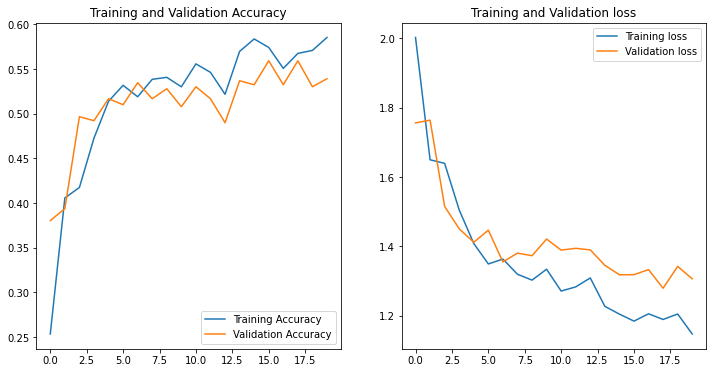

In [24]:
# Accuracy for train and validation dataset
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# Loss for train and validation dataset
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

# plotting the result
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend(loc="lower right")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend(loc="upper right")
plt.show()

Findings from the model:
- After applying data augmentation, we can see that overfitting problem has solved. There is not much difference in training accuracy and validation accuracy.
- But we can see that there is no improvement in accuracy.

Suggestions:
- Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance have a detrimental effect on the final model quality.
- Let's check the distribution of classes, if not balanced, we need to rectify the class imbalance using a useful package called Augmentor.

## Class Distribution and Handling Class Imbalance:

In [25]:
# Checking the summary dataframe
summary_df

,No_of_Train_Images,No_of_Test_Images
actinic keratosis,114,16
nevus,357,16
squamous cell carcinoma,181,16
vascular lesion,139,3
dermatofibroma,95,16
basal cell carcinoma,376,16
seborrheic keratosis,77,3
pigmented benign keratosis,462,16
melanoma,438,16


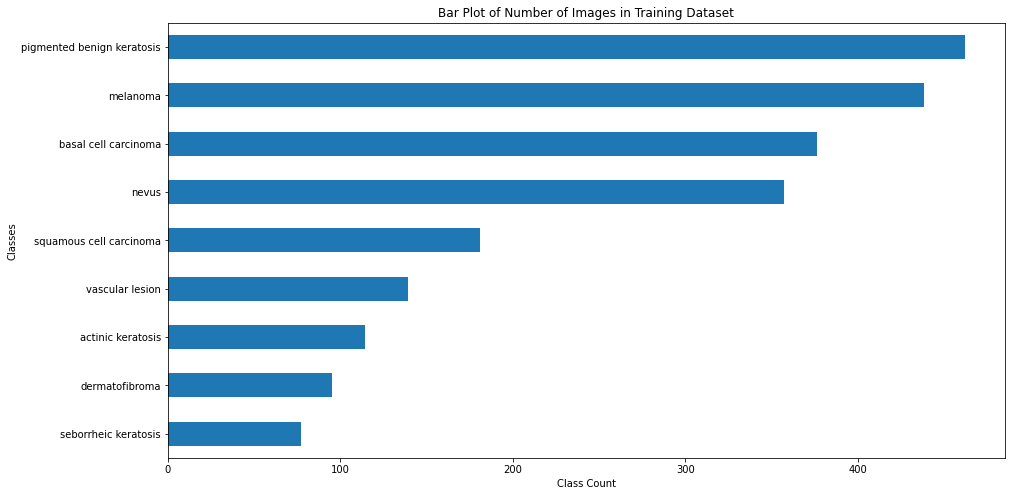

In [44]:
# Plotting the count plot
plt.figure(figsize=[15,8])
summary_df["No_of_Train_Images"].sort_values(ascending=True).plot.barh()
plt.title("Bar Plot of Number of Images in Training Dataset")
plt.xlabel("Class Count")
plt.ylabel("Classes")
plt.show()

Findings from the plot:
- Seborrheic keratosis has least number of samples
- Pigmented benign keratosis followed by melanoma have high proportionate number of samples, and Dermatofibroma and seborrheic keratosis have low proportionate number of samples.

Suggestion:
- In order to rectify the class imbalance we can use some data augmentation tool.
- We can use a python package called Augmentor to add more samples across all the classes so that none of the classes have fewer samples.

Handling Class Imbalance:

In [27]:
!pip install Augmentor

In [28]:
# Importing augmentor package
import Augmentor

# Defining a path to the training dataset
path_to_training_dataset= "/content/drive/MyDrive/Datasets/Skin cancer ISIC"
path_to_training_dataset = path_to_training_dataset + "/Train"
print(path_to_training_dataset)

for i in class_names:
  # Instantiating a pipeline object pointing to the directory containing initial train dataset
  p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
  
  # Defining the number of operations to be performed on train dataset
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

  # Let's add 500 samples per classes
  p.sample(500)

/content/drive/MyDrive/Datasets/Skin cancer ISIC/Train
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9EA60BADD0>: 100%|██████████| 500/500 [00:20<00:00, 24.07 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9EA614A890>: 100%|██████████| 500/500 [00:21<00:00, 23.74 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9F10038390>: 100%|██████████| 500/500 [00:23<00:00, 21.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9EA6108850>: 100%|██████████| 500/500 [01:36<00:00,  5.20 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9EA6100ED0>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F100F8590>: 100%|██████████| 500/500 [00:18<00:00, 27.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F9EA61A7F10>: 100%|██████████| 500/500 [00:42<00:00, 11.81 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F10039D50>: 100%|██████████| 500/500 [00:18<00:00, 27.67 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9EA61B3410>: 100%|██████████| 500/500 [00:18<00:00, 26.95 Samples/s]


In [29]:
# Checking the total count of augmented images
data_dir_train = pathlib.Path(path_to_training_dataset)
print(data_dir_train)

/content/drive/MyDrive/Datasets/Skin cancer ISIC/Train


In [30]:
# Checking the image count
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [31]:
# Creating the path list of all the images in the output directory
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

# Checking the first 10 paths of the path_list
print(len(path_list))
path_list[0:10]

4500


['/content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_3aee6749-b89a-4a6c-874b-37b710c28b17.jpg',
 '/content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_4d7ff255-0457-4f48-9536-babe28e920e1.jpg',
 '/content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032437.jpg_abc2706d-1e7d-468d-9545-08fcb90a36b0.jpg',
 '/content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031381.jpg_ea5d3437-4f3f-4a68-9a54-16883477afc8.jpg',
 '/content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_07220b23-94af-4d0b-81ae-e62d8f9d6682.jpg',
 '/content/drive/MyDrive/Datasets/Skin cancer ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_17c371f5-93e3-4b2e-b180-e1882

In [32]:
# Creating a list of class names from the output directory
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

# Checking the first 10 elements of the lesion_list_new
print(len(lesion_list_new))
lesion_list_new[1:10]

4500


['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [33]:
# Creating a dict with elements of path_list_new as key and lesion_list_new as values
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

# Creating a list of class names and path of original datasets
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))

# Combining two dictionaries into a single dataframe
original_df = pd.DataFrame(list(dataframe_dict.items()), columns=["Path","Label"])
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=["Path","Label"])
new_df = original_df.append(df2)

# Checking the value counts of new_df lables
new_df["Label"].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

## Model Building using Balanced Data

Defining some parameters:

In [34]:
# Defining some parameters
batch_size = 32
img_height = 180
img_width = 180

Creating Training dataset:

In [35]:
# Creating train dataset
data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split=0.2, 
    subset="training",
    image_size=(img_height, img_width),
    batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [36]:
# Creating validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [37]:
# Let's use autotune to determine the CPU budget to use for buffer_size while using prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Using prefetch to boost execution performance and caching for keeping the images in memory for the consecutive epochs
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the model using balanced data:

In [38]:
# Checking the summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Normalizing the new images created:

In [39]:
# Defining a normalization layer
Normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# Applying Normalization to the train dataset and ensuring the max and min values
normalized_ds = train_ds.map(lambda x,y :(Normalization_layer(x),y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[1]

# Noticing the maximum and minimum values of the selected image
print(np.min(first_image), np.max(first_image))

0.0007550931 0.7709352


Compiling the model:

In [40]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model:

In [41]:
# Training the model
epochs = 35

# Fitting the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/35


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 11s 58ms/step - loss: 1.3143 - accuracy: 0.4974 - val_loss: 1.1984 - val_accuracy: 0.5241
Epoch 2/35
169/169 [==============================] - 4s 24ms/step - loss: 1.2376 - accuracy: 0.5317 - val_loss: 1.2329 - val_accuracy: 0.5197
Epoch 3/35
169/169 [==============================] - 4s 23ms/step - loss: 1.2172 - accuracy: 0.5352 - val_loss: 1.1633 - val_accuracy: 0.5486
Epoch 4/35
169/169 [==============================] - 4s 23ms/step - loss: 1.1752 - accuracy: 0.5491 - val_loss: 1.1602 - val_accuracy: 0.5627
Epoch 5/35
169/169 [==============================] - 4s 23ms/step - loss: 1.1374 - accuracy: 0.5636 - val_loss: 1.1456 - val_accuracy: 0.5702
Epoch 6/35
169/169 [==============================] - 4s 23ms/step - loss: 1.1209 - accuracy: 0.5779 - val_loss: 1.1406 - val_accuracy: 0.5509
Epoch 7/35
169/169 [==============================] - 4s 23ms/step - loss: 1.1205 - accuracy: 0.5760 - val_loss: 1.0829 - val_accuracy: 0.6036
Epoch 8/3

Visualizing the model performance:

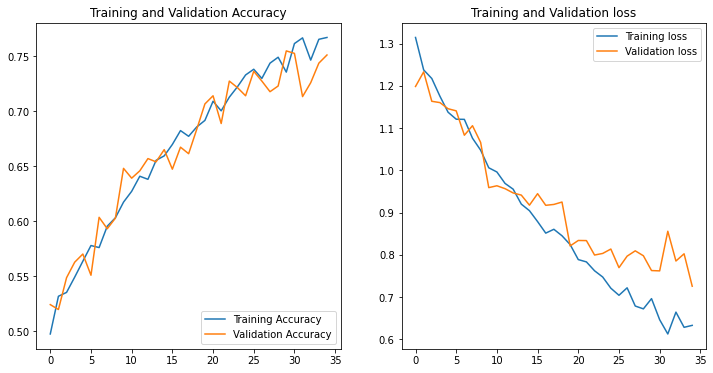

In [42]:
# Accuracy for train and validation dataset
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# Loss for train and validation dataset
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

# plotting the result
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend(loc="lower right")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend(loc="upper right")
plt.show()

Did you get rid of underfitting/overfitting? Did class rebalance help?
- Yes, from the above plot, we can see that the overfitting problem has resolved, as there is no high variance between training and validation loss.
- Yes, after class rebalancing both training accuracy and validation accuracy improved significantly with train accuracy from 59.5% to 76.7% and validation accuracy from 54% to 75%.